### Heart Disease Risk Prediction and Early-Stage Heart Disease detection

In [1]:
import pandas as pd
import altair as alt
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer

import requests
import zipfile

### Summary

We wish to create a simple machine learning classification model which can help us predict high risk individuals for heart disease. We try three methods: Decision Tree Classifier, Logistic Regression and Support Vector Machine with Radial Basis Function (RBF) Kernel to use 14 common features related to heart disease to make the predictions. Here we aimed to find the best model that predicts whether an individual is at risk of developing heart disease based on their clinical features, enabling early identification and prevention measures. 

We have selected F2 score as our primary performance metric since our primary goal is to minimize False Negatives - cases where patients at risk of heart disease are incorrectly identified as healthy. The final classifier SVM RBF performed reasonably well on the unseen test dataset, achieving an F2 score (β = 2) of 0.9646 and an overall accuracy of 0.98. Out of the 200 test data cases, it correctly predicted 196 and misclassified 4, which are all False Positives - predicting that a patient is at risk of developing heart disease when they are in fact healthy. False positives are not as dangerous as False Negatives. Although they could theoretically cause the patient to undergo unnecessary treatment if the model is used as a decision tool, we expect there to be additional decision layers which can mitigate this. As such, we believe this model serves as a valuable decision-support tool, assisting medical professionals in identifying high-risk individuals for closer monitoring and timely intervention.

### Introduction

According to the American Heart Association (n.d.),Heart disease, or Coronary Artery Disease is a condition in which narrowed coronary arteries reduce blood flow to the heart. This can lead to heart attack- where the heart can stop working, and in many cases leaves a very narrow window of time for responsive action. Data from the World Health Organization (n.d.) shows that, in India, a country of approximately 1.4 billion people, heart disease has consistently been the leading cause of death over the past decade (2010–2020) for both genders.

Cardiovascular diseases or CVDs account for about 31% of all deaths, according to the latest Sample Registration System report (Press Trust of India, 2025). India’s age-standardized CVD death rate is estimated at 272 per 100,000, significantly higher than the global average of approximately 235 per 100,000 (Prabhakaran et al., 2016). 

If high-risk individuals can be identified before clinical events such as heart attacks, early interventions like the few recommended by the National Heart, Lung, and Blood Institute (n.d.) can reduce mortality rate. The list includes simple lifestyle changes, to medicines like statins which can reduce plaque buildup, to medical procedures in necessary cases.

Since traditional diagnosis often depends on physician expertise, subjective assessment, and resource-intensive tests, a data-driven predictive model could therefore help identify patients who are more prone to such events, especially in resource-limited settings (Gupta et al., 2018).

Thus, even minor improvements or supplementary methods in early detection could make a meaningful difference in population health. In this project, we attempt to use measurable, structured features to identify high-risk cases, enabling more careful monitoring and earlier preventive measures.

### Methods

#### 1. Data

The dataset contains 1000 unique examples and 14 features containing information on the individuals cholesterol, blood pressure and fasting blood sugar. We are using 13 features and dropping the patient ID feature for our analysis. Our target column contains binary encoding where 1 translates to 'heart disease' and 0 to 'no heart disease'. This dataset has been acquired from Doppala and Bhattacharyya, 2021. Each row in the data set represents summary statistics from one single patient.

The data was collected from multispecialty hospital in India. From the same source, a detailed explanation of all the important features are provided to get a better overview of the summary statistics for all numerical columns along with the dataset, which is included in the repository and available in the data folder [here](https://github.com/sjbalagit/Heart-Disease-Predictor---Group16/blob/main/data/raw/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset_Description.pdf).

The source dataset has **no missing values** and has a total of 14 numerical columns including the target.

#### 2. Analysis

**2.1 Importing the data and preliminary EDA**

We will read and save the data from the url to the data folder.

In [2]:
url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/dzz48mvjht-1.zip"

request = requests.get(url)
with open("./data/raw/Cardiovascular_Disease_Dataset_original.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("./data/raw/Cardiovascular_Disease_Dataset_original.zip", 'r') as zip_ref:
    zip_ref.extractall("./data/raw")

In [3]:
df = pd.read_csv('./data/raw/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv')
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


_Table 1: Raw Input Data - First 5 Rows_

This section provides a detailed exploration of the dataset, focusing on the distribution of features, relationships with the target variable and insights that support later preprocessing and modeling.

#### Initial Data Inspection

Basic inspection functions such as head, shape and info help understand the dataset’s structure. They show the first few rows, dimensions of the data and confirm that all 14 columns contain complete, non-null values. 

In [4]:
print(df.shape)
print(df.info())

(1000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB
None


#### Splitting Data into Training and Test Sets

The dataset is split into training (80%) and testing (20%) subsets to support unbiased modeling. Using a fixed random state ensures that the split is reproducible. EDA is performed on the training data to prevent information leakage.

In [5]:
train_df, test_df = train_test_split(df, test_size = 0.2,random_state=123)

train_df.to_csv("./data/processed/heart_train.csv")
test_df.to_csv("./data/processed/heart_test.csv")

#### Summary Statistics

Descriptive statistics are generated to understand the range, central tendencies and variability of each numerical feature. This helps identify unusual values, potential outliers and general data distribution patterns.

In [6]:
# summary statistics 
summary = train_df.describe(include="all")
summary

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,8.000000e+02,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5.024844e+06,49.102500,0.762500,0.950000,151.150000,310.745000,0.297500,0.738750,145.361250,0.507500,2.651625,1.512500,1.206250,0.565000
std,2.869843e+06,17.796851,0.425817,0.950594,29.905651,132.660869,0.457444,0.764021,34.817827,0.500257,1.720304,1.019138,0.975911,0.496067
min,1.033680e+05,20.000000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.546342e+06,33.000000,1.000000,0.000000,129.000000,234.000000,0.000000,0.000000,118.000000,0.000000,1.200000,1.000000,0.000000,0.000000
50%,4.958079e+06,49.000000,1.000000,1.000000,146.500000,318.000000,0.000000,1.000000,146.000000,1.000000,2.400000,2.000000,1.000000,1.000000
75%,7.533967e+06,64.000000,1.000000,2.000000,180.000000,404.000000,1.000000,1.000000,176.000000,1.000000,3.900000,2.000000,2.000000,1.000000
max,9.990855e+06,80.000000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


_Table 2: Summary Statistics of Input Data_

#### Visualizing Target Distribution

A bar chart is created to show the number of patients with and without heart disease. This visualization highlights if the dataset is balanced or skewed, which is important for model performance and evaluation. 

The bar chart shows that heart disease is more common than non-heart disease in the dataset, with 398 cases of heart disease compared to 302 without heart disease. Although there is an imbalance between the levels but this level of imbalance is not substantial and is unlikely to affect the model negatively.

In [7]:
# Compute counts and percentages grouped by target
counts = train_df.groupby('target').size().reset_index(name='count')
counts['label'] = counts['target'].map({0: 'No Heart Disease', 1: 'Heart Disease'})

# Bar chart of counts
bar = alt.Chart(counts).mark_bar(stroke='black', strokeWidth=1).encode(
    x=alt.X('label:N', title='Heart Disease', sort=['No Heart Disease', 'Heart Disease']),
    y=alt.Y('count:Q', title='Count'),
    color=alt.Color(
        'label:N',
        title='Heart Disease',
        sort=['No Heart Disease', 'Heart Disease']
    ),
    tooltip=[
        alt.Tooltip('count:Q', title='Count')
    ]
).properties(
    title='Cases of Heart Disease',
    width=300,
    height=300
)

# Text labels above each bar
bar_labels = bar.mark_text(
    dy=-5,
    size=14,
).encode(
    text='count:Q'
)

bar_final = bar + bar_labels
bar_final

alt.LayerChart(...)

_Figure 1: Distribution of Target Variable in Input Data_

#### Distribution of Numerical Features

Histograms are used to visualize the distribution of numerical variables such as age, resting blood pressure and cholesterol. These plots help identify skewness, outliers and typical value ranges within the dataset.

From the distributions of the continuous feature below, it can be observed that none of the features follow a normal distribution. Age is spread out evenly across the entire range, so there isn’t one age group that dominates the dataset. Resting blood pressure is mostly clustered around the middle values, with fewer people having very high readings, which makes it slightly right-skewed. Serum cholesterol is right-skewed; a lot of people have lower cholesterol values, and only a few fall into the very high range. Max heart rate,is in the opposite direction and is slightly left-skewed, which means that more people reach higher heart rate values than lower ones. Lastly, oldpeak is also right-skewed, with most patients showing very low values and only a small number having higher values.

In [8]:
num_cols = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'oldpeak']

charts = []

for col in num_cols:
    chart = alt.Chart(train_df).mark_bar().encode(
        x=alt.X(f'{col}:Q', bin=alt.Bin(maxbins=30)),
        y=alt.Y('count()', title='Count'),
        tooltip=[alt.Tooltip(f'{col}:Q', title=col), alt.Tooltip('count()', title='Count')]
    ).properties(
        title=f'Distribution of {col}',
        width=300,
        height=250
    )
    charts.append(chart)

# rows of 2 charts each
rows = []
for i in range(0, len(charts), 2):
    row_charts = charts[i:i+2]   # take 2 charts (or remaining 1)
    row = alt.hconcat(*row_charts)
    rows.append(row)

final_chart = alt.vconcat(*rows).configure_legend(
    orient='top'
)

final_chart


alt.VConcatChart(...)

_Figure 2: Histograms of Numerical Features_

#### Boxplots of Numerical Features vs Target

Boxplots compare each numerical feature across the two target classes. They reveal patterns or differences, for example, whether higher blood pressure or older age is more common among patients with heart disease.

The boxplots show how people with heart disease differ from those without it. From the age chart, people with heart disease are generally older, while younger people mostly fall in the no heart disease group. For resting blood pressure, those with heart disease tend to have slightly higher values, showing that high blood pressure may be linked to heart disease. Although there are outliers for no heart disease, this means that some individuals have high blood pressure but do not have heart disease. The boxplot for serum cholesterol shows that the cholesterol levels are a bit higher and more spread out among people who have heart disease. The maximum heart rate chart shows that people without heart disease reach higher heart rates, while those with heart disease have lower maximum heart rates. This usually means their heart cannot handle as much physical stress. Oldpeak is higher in people with heart disease, which means their heart experiences more stress changes. 

In [9]:
train_df['label'] = train_df['target'].map({0: 'No Heart Disease', 1: 'Heart Disease'})

charts = []

for col in num_cols:
    chart = alt.Chart(train_df).mark_boxplot(size=20).encode(
        x=alt.X(f'{col}:Q', title=col),
        y=alt.Y('label:N', title='Heart Disease'),
        color=alt.Color('label:N', title='Heart Disease')
    ).properties(
        title=f'{col} vs Heart Disease',
        width=300,
        height=250)
    charts.append(chart)

rows = []
for i in range(0, len(charts), 2):
    row_charts = charts[i:i+2]
    row = alt.hconcat(*row_charts)
    rows.append(row)

final_chart = alt.vconcat(*rows).configure_legend(
    orient='top')

final_chart

alt.VConcatChart(...)

_Figure 3: Boxplots of Numeric Features_

#### Categorical Features vs Target

Grouped bar charts are used to compare categorical variables (e.g., gender, chest pain type) against the target variable. This identifies category-level patterns and helps determine how these features relate to heart disease.

The gender chart shows that more males were diagnosed with heart disease compared to females. The chest-pain chart shows that more people with typical chest pain have no heart disease, while Atypical and non-anginal chest pain tend to have higher heart-disease counts. Also, asymptomatic patients appear less among healthy individuals and more among those with heart disease.

For fasting blood sugar, most people fall in the normal range, and the heart-disease group is only slightly higher than the no-disease group. In the high blood-sugar category, the numbers are low for both, but individuals with heart disease are significantly higher than those without heart disease.

People without heart disease are more in the normal ECG category, while people with heart disease are more in the ST-T Abnormality and LVH categories. Exercise-induced angina clearly shows that people with chest pain during exercise are much more likely to have heart disease. The number of major blood vessels chart shows that people with a higher number of vessels tend to have higher heart disease counts. Finally, the slope of the ST segment shows that certain ECG patterns, like a flat or down-sloping ST, are more common in those with heart disease.

In [10]:
cat_cols = ['gender','chestpain','fastingbloodsugar','restingrelectro','exerciseangia','slope','noofmajorvessels']
axis_titles = {
    'gender': 'Gender (0 = Female, 1 = Male)',
    'chestpain': 'Chest Pain Type (0=Typical, 1=Atypical, 2=Non-anginal, 3=Asymptomatic)',
    'fastingbloodsugar': 'Fasting Blood Sugar (0 = ≤120 mg/dl, 1 = >120 mg/dl)',
    'restingrelectro': 'Resting ECG (0=Normal, 1=ST-T Abnormality, 2=LVH)',
    'exerciseangia': 'Exercise-Induced Angina (0 = No, 1 = Yes)',
    'slope': 'Slope of ST Segment (1=Upsl, 2=Flat, 3=Downsl)',
    'noofmajorvessels': 'No. of Major Vessels (0-3)'}

train_df['label'] = train_df['target'].map({0: 'No Heart Disease', 1: 'Heart Disease'})

charts = []

for col in axis_titles.keys():
    chart = alt.Chart(train_df).mark_bar(size=30).encode(
        x=alt.X(
            f'{col}:N',
            title=axis_titles[col],     
            scale=alt.Scale(paddingInner=0.5, paddingOuter=0.5)),
        xOffset='label:N',
        y=alt.Y('count()', title='Count'),
        color=alt.Color('label:N', title='Heart Disease'),
        tooltip=[alt.Tooltip('count()', title='Count')]).properties(
        title=f'{col} vs Heart Disease',
        width=300,
        height=250)
    charts.append(chart)


rows = []
for i in range(0, len(charts), 2):
    rows.append(alt.hconcat(*charts[i:i+2]))

final_chart = alt.vconcat(*rows).configure_legend(
    orient='top')
final_chart

alt.VConcatChart(...)

_Figure 4: Distribution of Categorical Features_

#### Correlation Heatmap

A correlation matrix is computed and visualized using a heatmap to show linear relationships among features. This helps detect multicollinearity and highlights variables that may have strong predictive relationships with the target.

Darker blue cells represent stronger positive correlations, while darker red cells represent stronger negative correlations. From the heatmap, the feature slope has the strongest positive relationship with the target, followed by chest pain, resting BP, and number of major vessels. This means these features are more likely to influence whether someone has heart disease. On the other hand, features like age, gender, and exercise angia show very low or almost no correlation with the target, suggesting they don’t have a strong direct relationship with the target. It can also be seen that some features are related to each other. For example, number of major vessels and slope have a moderate positive correlation.

In [11]:
corr_matrix = train_df[num_cols + cat_cols + ['target']].corr()
corr_long = corr_matrix.reset_index().melt(id_vars='index')
corr_long.columns = ['feature_x', 'feature_y', 'correlation']

base = alt.Chart(corr_long).encode(
    x=alt.X('feature_x:N', title='Feature'),
    y=alt.Y('feature_y:N', title='Feature'))

heatmap = base.mark_rect().encode(
    color=alt.Color(
        'correlation:Q',
        scale=alt.Scale(scheme='redblue', domain=[-1, 1])),
    tooltip=['feature_x', 'feature_y'])

text = base.mark_text(
    fontSize=12,
    color='black').encode(
    text=alt.Text('correlation:Q', format='.2f'))

final_chart = (heatmap + text).properties(
    title='Correlation Heatmap of All Features with Target',
    width=600,
    height=600)

final_chart

alt.LayerChart(...)

_Figure 5: Correlation Heatmap for All Features_

#### Summary of Feature Transformations

Each feature is assigned an appropriate preprocessing method: numerical features are scaled using StandardScaler, categorical features are one-hot encoded and the patient ID is removed since it has no predictive value. This ensures the data is model-ready.

| Feature | Transformation | Explanation |
| --- | ----------- | ----- |
| patientid | drop | Unique identifier for each patient. Not predictive, so removed from modeling. |
| age | scaling with `StandardScaler` |  A numeric feature with no missing values, ranging from 20 to 80. Scaling is recommended due to its distinct range compared to other numeric features.|
| chestpain | one-hot encoding |  categorical column with no missing values |
| exerciseangia | Passthrough (binary) |  Categorical column kept as it is and will be handled by the model directly|
| fastingbloodsugar | Passthrough (binary) | Categorical column kept as it is and will be handled by the model directly|
| gender | Passthrough (binary) | Categorical column kept as it is and will be handled by the model directly|
| maxheartrate | scaling with `StandardScaler`  | A numeric feature with no missing values, ranging from 20 to 80. Scaling is recommended due to its distinct range compared to other numeric features.|
| noofmajorvessels | scaling with`StandardScaler` | A numeric feature with no missing values, ranging from 0 to 3. Scaling is recommended due to its distinct range compared to other numeric features.|
| oldpeak | scaling with `StandardScaler` | A numeric feature with no missing values, ranging from 0 to 3. Scaling is recommended due to its distinct range compared to other numeric features.|
| restingBP | scaling with `StandardScaler` | A numeric feature with no missing values, ranging from 94 to 200. Scaling is recommended due to its distinct range compared to other numeric features. |
| restingelectro | one-hot encoding| categorical column with no missing values|
| serumcholestrol |  scaling with `StandardScaler` | A numeric feature with no missing values, ranging from 0 to 602. Scaling is recommended due to its distinct range compared to other numeric features.| 
| slope |  ordinal encoding with `OrdinalEncoder` | categorical column with an ordinal relation among the features |

_Table 3: Preprocessing for the columns_

**2.2 Data Prep: Splitting target column and feature column cleanup**

Before we start working on anything we will separate the test data from the training data to avoid violating the golden rule.

In [12]:
X_train = train_df.drop(columns = ['target'])
y_train = train_df['target']
X_test = test_df.drop(columns = ['target'])
y_test = test_df['target']

X_train.to_csv('./data/processed/train_data.csv')
X_test.to_csv('./data/processed/test_data.csv')

We can now clean up the data according to the criteria for each column.

In [13]:
binary = ['gender','fastingbloodsugar','exerciseangia']
ohe = ['chestpain','restingrelectro']
numerical = ['age','restingBP','serumcholestrol','maxheartrate','oldpeak','noofmajorvessels']
ordinal = ['slope']
drop = ['patientid']

preprocessor = make_column_transformer(
 (StandardScaler(), numerical),
 (OneHotEncoder(), ohe),
 (OrdinalEncoder(), ordinal),
 ('passthrough', binary),
 ('drop', drop)
)

We can view the first 5 rows of the preprocessed data to have an idea of what we are going to input into our model.

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
column_names = (
 numerical
 + ordinal
 + binary
 + preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(ohe).tolist())
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = column_names)
X_train_preprocessed.head(5)

,age,restingBP,serumcholestrol,maxheartrate,oldpeak,noofmajorvessels,slope,gender,fastingbloodsugar,exerciseangia,chestpain_0,chestpain_1,chestpain_2,chestpain_3,restingrelectro_0,restingrelectro_1,restingrelectro_2
0,1.512308,-0.272694,-0.352585,-0.412726,-0.786181,-0.211473,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.005763,0.731088,-0.488354,1.196651,-0.204525,-0.211473,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0
2,1.118734,0.162278,0.929680,1.455301,-0.728015,-0.211473,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,0.0
3,-1.411385,0.429953,0.778825,-0.556421,1.075119,-0.211473,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0
4,1.006285,1.299898,-0.103675,-0.355249,-0.611684,-0.211473,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0


_Table 4 Preprocessed columns_

In [15]:
X_train_preprocessed.to_csv('./data/processed/train_preprocessed.csv')

X_test_preprocessed = preprocessor.transform(X_test)
column_names = (
 numerical
 + ordinal
 + binary
 + preprocessor.named_transformers_['onehotencoder'].get_feature_names_out(ohe).tolist())
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = column_names)
X_test_preprocessed.to_csv('./data/processed/test_preprocessed.csv')

**2.3 Scoring Metric**

We will select the F2 score for checking the performance of the model since this is a medical problem and we reason that false negatives are much more harmful than false positives, and we wish to catch as many possible cases as we can. Choosing the F2 score will enable us to measure precision and recall instead of accuracy, and give recall a 2x weight so that we try to reduce false negatives as much as possible.

$$
F_{\beta} = (1+\beta^2) . \frac{precision \times recall}{\beta^2 precision + recall}
$$

with $\beta = 2$ will give us the F2 score.

**2.4 Model Tuning**

We will be looking at three models: Logistic Regression, Support Vector Machine (SVM) and Decision Tree Classifier. We have attributed the `mean_std_cross_val_score` function from DSCI571 to get a summary of the mean and standard deviation for the cross validation scores from each model. Based on these results, we can use RandomizedSearchCV for each model to tune their main hyperparameters.

In [16]:
# Function adapted from DSCI 571
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
models = {
    "dummy clf":DummyClassifier(strategy='most_frequent'),
    "decision tree": DecisionTreeClassifier(random_state=123),
    "Logistic Regression": LogisticRegression(random_state=123),
    "RBF SVM": SVC(random_state=123),
}

results_dict = dict()

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)

    results_dict[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True,
        scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
    
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy clf,0.002 (+/- 0.000),0.002 (+/- 0.000),0.867 (+/- 0.002),0.867 (+/- 0.000)
decision tree,0.003 (+/- 0.000),0.002 (+/- 0.000),0.956 (+/- 0.013),1.000 (+/- 0.000)
Logistic Regression,0.006 (+/- 0.002),0.002 (+/- 0.000),0.958 (+/- 0.012),0.971 (+/- 0.005)
RBF SVM,0.007 (+/- 0.002),0.003 (+/- 0.000),0.964 (+/- 0.010),0.987 (+/- 0.004)


_Table 5: 5-fold CV scores for different models with default parameters_

Above, we have the cross validation scores for each model with no hyperparameters specified, so now we can move ahead and specify a parameter grid over which our RandomizedSearchCV can search for the best parameters. We have particularly decided to do this process over all the models to see how the f2 score compare for the best parameters.

In [18]:
tree_param_dist = {
    'decisiontreeclassifier__max_depth': np.arange(1, 11)
}
tree_model = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
search_tree = RandomizedSearchCV(tree_model, tree_param_dist, return_train_score=True,
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_tree.fit(X_train, y_train)
search_tree.best_params_, search_tree.best_score_

({'decisiontreeclassifier__max_depth': np.int64(9)},
 np.float64(0.9556743725768253))

In [19]:
logistic_param_dist = {
    "logisticregression__C" : 10.0 ** np.arange(-3, 2, 1),
    "logisticregression__max_iter" : [80, 100, 500, 1000, 1500, 2000]
}
log_model = make_pipeline(preprocessor, LogisticRegression(random_state=123))
search_log = RandomizedSearchCV(log_model, logistic_param_dist, return_train_score=True,
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_log.fit(X_train, y_train)
search_log.best_params_, search_log.best_score_

({'logisticregression__max_iter': 2000,
  'logisticregression__C': np.float64(0.1)},
 np.float64(0.9602223627705779))

In [20]:
SVM_param_dist = {
    "svc__C": 10.0 ** np.arange(-3, 2, 1),
    "svc__gamma": 10.0 ** np.arange(-3, 2, 1)
}
svm_model = make_pipeline(preprocessor, SVC(random_state=123))
search_svm = RandomizedSearchCV(svm_model, SVM_param_dist, return_train_score=True,
                                 n_jobs=-1, scoring=make_scorer(fbeta_score, pos_label=1, beta=2))
search_svm.fit(X_train, y_train)
search_svm.best_params_, search_svm.best_score_

({'svc__gamma': np.float64(0.1), 'svc__C': np.float64(1.0)},
 np.float64(0.9646153314734971))

In [21]:
#Build Final Models with Best Parameters
best_model = make_pipeline(preprocessor, SVC(C=1, gamma=0.1, random_state=123))
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.98

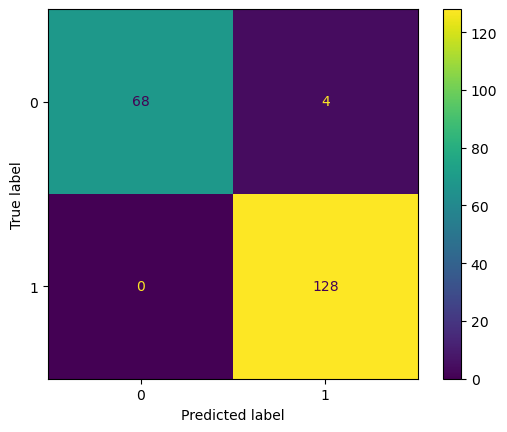

In [22]:
cm = ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
)

_Figure 6:  Confusion matrix of model performance on test data._

### Results and Discussion

**Final model selection**

There has been extensive work that has been conducted prior to reaching the final model selection. We had preprocessed the data, did a preliminary EDA, checked the cross-validation for the three different models and finally used RandomizedSearchCV to get the best parameters and scores for each model. The results indicate that the SVM model with RBF gave a best validation score of 0.9646, which is slightly better than the scores of the other two models. Our final step was to build the best model using the best parameters and then fit on training data and score on the test. Surprisingly, the final test score was 0.98, which is greater than the validation score we achieved. 

There are two possible reasons which could have led to this result. One could be that the test data contained examples which were similar to the training set and as a result the test score was better. This is the likely reason as we ensured throughout the entire coding process to have the test data kept seperate from the training and validation sets. There was no leakage of information from the test set to the training set, as per the steps illustrated in this report. The second reason that is less likely but important to also consider is that we do not have enough data in the test to substantiate it as a good proxy for how unseen data would be. We maintained the 70-30 split for training and testing data, which was our pre-decided split size, so we still think that the first reason might be a better explanation for such high score. 

**Conclusion**

So, putting all of the results and analysis together, the selected model is the SVM with RBF model with hyperparameters C=1 and gamma=0.1. Since, our predictions are conducted over whether an individual is going to get heart disease or not, we must ensure that there is as minimal false negatives as possible. From the confusion matrix created for visualization, we can rest assured the the false negatives are not a matter of issue for SVM model. All in all, SVM with RBF model is most appropriate for our binary classification problem.

### References

1. Press Trust of India. (2025, September 5). Cardiovascular diseases cause one-third of all deaths in India: Report. Business Standard. https://www.business-standard.com/amp/health/cardiovascular-diseases-cause-one-third-of-all-deaths-in-india-report-125090500028_1.html
2. Prabhakaran, D., Jeemon, P., & Roy, A. (2016). Cardiovascular diseases in India: Current epidemiology and future directions. Circulation, 133(16), 1605–1620. https://doi.org/10.1161/CIRCULATIONAHA.114.008729
3. Gupta, R., Khedar, R. S., Gaur, K., & Xavier, D. (2018). Low quality cardiovascular care is important coronary risk factor in India. Indian Heart Journal, 70(Suppl 3), S419–S430. https://doi.org/10.1016/j.ihj.2018.05.002
4. Doppala, B. P., & Bhattacharyya, D. (2021). Cardiovascular_Disease_Dataset (Version 1) [Data set]. Mendeley Data. https://doi.org/10.17632/dzz48mvjht.1
5. World Health Organization. (n.d.). India — Health data overview. WHO. Retrieved November 18, 2025, from https://data.who.int/countries/356
6. American Heart Association. (n.d.). Ischemic Heart Disease and Silent Ischemia. Retrieved [date], from https://www.heart.org/en/health-topics/heart-attack/about-heart-attacks/silent-ischemia-and-ischemic-heart-disease
7. World Health Organization. (n.d.). Leading causes of death. WHO Global Health Observatory. Retrieved November 21, 2025, from https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates/ghe-leading-causes-of-death
8. National Heart, Lung, and Blood Institute. (n.d.). Treatment of coronary heart disease. NIH. Retrieved November 21,  2025, from https://www.nhlbi.nih.gov/health/coronary-heart-disease/treatment
